In [1]:
!pip install torchtext==0.6.0 nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvi

# Data Preparation

In [2]:
import torch
from torch.utils.data import DataLoader
from datasets import load_from_disk
from transformers import PreTrainedTokenizerFast
import sys

class NMTDataModule:
    def __init__(self, data_path, tokenizer_en_path, tokenizer_fr_path, batch_size=32, max_length=32):
        self.batch_size = batch_size
        self.max_length = max_length

        
        print(f"Loading tokenizers...")
        self.tokenizer_en = PreTrainedTokenizerFast.from_pretrained(tokenizer_en_path)
        self.tokenizer_fr = PreTrainedTokenizerFast.from_pretrained(tokenizer_fr_path)

        # Set pad tokens if not already set
        if self.tokenizer_en.pad_token is None:
            self.tokenizer_en.pad_token = "<pad>"
        if self.tokenizer_fr.pad_token is None:
            self.tokenizer_fr.pad_token = "<pad>"
            
        
        self._verify_tokenizers()

        
        print(f"Loading dataset...")
        self.dataset = load_from_disk(data_path)

    def _verify_tokenizers(self):
        """
        check if the tokenizer adds <s> and </s>.
        """
        test_str = "hello"
        encoded = self.tokenizer_en.encode(test_str)
        decoded = self.tokenizer_en.decode(encoded)
        
        # Check for BOS/EOS IDs (Assuming 1=<s>, 2=</s> based on our JSON)
        has_bos = (encoded[0] == 1)
        has_eos = (encoded[-1] == 2)
        
        print(f"\n--- Tokenizer Sanity Check ---")
        print(f"Input: '{test_str}' -> IDs: {encoded}")
        print(f"Decoded: '{decoded}'")
        print(f"Starts with BOS (1)? {has_bos}")
        print(f"Ends with EOS (2)? {has_eos}")
        
        if not has_bos or not has_eos:
            print("WARNING: our tokenizer is NOT adding BOS/EOS automatically.")
            
        else:
            print("Tokenizer is correctly adding special tokens.")
        print("------------------------------\n")

    def collate_fn(self, batch):
        
        en_texts = [item['text_en'] for item in batch]
        fr_texts = [item['text_fr'] for item in batch]

        
        src = self.tokenizer_fr(
            fr_texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        
        trg = self.tokenizer_en(
            en_texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        
        # The full target is: <s> I love cats </s> <pad>
        
        # 1. decoder_input_ids: Input to the Decoder (Shifted Right)
        # We want: <s> I love cats <pad>
        # We remove the LAST token from the sequence
        decoder_input_ids = trg["input_ids"][:, :-1]
        
        # 2. labels: The Ground Truth for Loss Calculation (Shifted Left)
        # We want: I love cats </s> <pad>
        # We remove the FIRST token (<s>) from the sequence
        labels = trg["input_ids"][:, 1:]

        # 3. decoder_mask: Attention mask for the input
        decoder_attention_mask = trg["attention_mask"][:, :-1]

        return {
            # Encoder Inputs
            "src_ids": src["input_ids"],
            "src_mask": src["attention_mask"],
            
            # Decoder Inputs (for Teacher Forcing)
            "decoder_input_ids": decoder_input_ids,
            "decoder_mask": decoder_attention_mask,
            
            # Ground Truth (for Loss)
            "labels": labels,
            
            # Full Target (Useful for reference/BLEU)
            "trg_ids_full": trg["input_ids"]
        }

    def get_dataloaders(self):
        train_loader = DataLoader(self.dataset['train'], batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)
        val_loader = DataLoader(self.dataset['validation'], batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)
        test_loader = DataLoader(self.dataset['test'], batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)
        return train_loader, val_loader, test_loader



In [3]:
dm = NMTDataModule(
    data_path="/kaggle/input/parallel-french-and-english-sentences/resources/parallel_en_fr_corpus", 
    tokenizer_en_path="/kaggle/input/parallel-french-and-english-sentences/resources/tokenizer_en", 
    tokenizer_fr_path="/kaggle/input/parallel-french-and-english-sentences/resources/tokenizer_fr",
    batch_size=32
)


train_loader, val_loader, test_loader = dm.get_dataloaders()

for batch in train_loader:
    print("==="*50)
    print(len(train_loader))
    print("==="*50)
    print(batch)
    break

Loading tokenizers...

--- Tokenizer Sanity Check ---
Input: 'hello' -> IDs: [1, 51, 67, 22, 2]
Decoded: '<s> ▁he ll o </s>'
Starts with BOS (1)? True
Ends with EOS (2)? True
Tokenizer is correctly adding special tokens.
------------------------------

Loading dataset...
272
{'src_ids': tensor([[   1,   79,   79,  213, 1443,   36,    2,    3,    3,    3,    3,    3,
            3],
        [   1,   81,   57,   82, 2165, 3035,   36,    2,    3,    3,    3,    3,
            3],
        [   1,   90,   65,  124, 2765, 1669,   64, 1026,   36,    2,    3,    3,
            3],
        [   1,  169,   86,  125,   68,  251,  105,   36,    2,    3,    3,    3,
            3],
        [   1,   54,   65,   82,   41,   88,   73,   12,  142,   36,    2,    3,
            3],
        [   1,   81,  174,  693,  240,  119, 2759,   36,    2,    3,    3,    3,
            3],
        [   1,   81,   57,  209,  890,  236,  212,   36,    2,    3,    3,    3,
            3],
        [   1,   47,   60, 2431, 

# Model

## Builtin

In [4]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(
            self,
            embed_size,
            src_vocab_size,
            trg_vocab_size,
            src_pad_idx,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
            max_length,
            device
    ):
        super(Transformer, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.src_positional_embedding = nn.Embedding(max_length, embed_size)
        self.trg_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.trg_positional_embedding = nn.Embedding(max_length, embed_size)
        self.device = device

        self.transformer = nn.Transformer(
            embed_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        # src   => (src_len, N)
        # mask  => (N, src_len)
        return src.transpose(0, 1) == self.src_pad_idx

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_postions = (
            torch.arange(0, src_seq_length).unsqueeze(1).expand(src_seq_length, N).to(self.device)
        )

        trg_postions = (
            torch.arange(0, trg_seq_length).unsqueeze(1).expand(trg_seq_length, N).to(self.device)
        )

        embed_src = self.dropout(
            self.src_embedding(src) + self.src_positional_embedding(src_postions)
        )

        embed_trg = self.dropout(
            self.src_embedding(trg) + self.src_positional_embedding(trg_postions)
        )

        src_padding_mask = self.make_src_mask(src)
        trg_padding_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_padding_mask
        )

        return self.fc_out(out)


## Custom model

In [5]:
# Used for visualization

self_attention = None 
masked_attention = None
cross_attention = None

In [6]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()

        self.heads = heads
        self.embed_size = embed_size
        self.head_dim = embed_size // heads

        assert embed_size % heads == 0, "embed_size must be divisible by heads"

        self.q = nn.Linear(self.embed_size, self.embed_size, bias=False)
        self.k = nn.Linear(self.embed_size, self.embed_size, bias=False)
        self.v = nn.Linear(self.embed_size, self.embed_size, bias=False)
        self.fc_out = nn.Linear(self.embed_size, self.embed_size, bias=False)

    def forward(self, q, k, v, mask=None):

        N = q.size(0)
        q_len, k_len, v_len = q.size(1), k.size(1), v.size(1)

        q = self.q(q)
        k = self.k(k)
        v = self.v(v)

        # Reshape to (Batch, Seq_Len, Heads, Head_Dim)
        q = q.reshape(N, q_len, self.heads, self.head_dim)
        k = k.reshape(N, k_len, self.heads, self.head_dim)
        v = v.reshape(N, v_len, self.heads, self.head_dim)

        # Einsum: (N, Q_len, Heads, Head_Dim) * (N, K_len, Heads, Head_Dim) -> (N, Heads, Q_len, K_len)
        energy = torch.einsum("nqhd,nkhd->nhqk", [q, k])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        
        attention = torch.softmax(energy / (self.head_dim ** (1/2)), dim=3)
        global cross_attention
        cross_attention = attention
        # Einsum: (N, Heads, Q_len, K_len) * (N, V_len, Heads, Head_Dim) -> (N, Q_len, Heads, Head_Dim)
        out = torch.einsum("nhqk,nkhd->nqhd", [attention, v])

        # -1 => embed_size
        out = out.reshape(N, q_len, -1)

        return self.fc_out(out)

In [7]:
import torch
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.fft = nn.Sequential(
            nn.Linear(embed_size, embed_size * forward_expansion),
            nn.ReLU(),
            nn.Linear(embed_size * forward_expansion, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        att = self.attention(q=q, k=k, v=v, mask=mask)
        out1 = self.dropout(self.norm1(att + q))
        out2 = self.fft(out1)
        return self.dropout(self.norm2(out2 + out1))

In [8]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(
            self,
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device

        self.embed_layer = nn.Embedding(src_vocab_size, embed_size)
        self.positional_encoding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList([
            TransformerBlock(
                embed_size=embed_size,
                num_heads=heads,
                dropout=dropout,
                forward_expansion=forward_expansion,
            )
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, mask):
        N, seq_len = src.size()

        position_embedding = torch.arange(0, seq_len, device=src.device).expand(N, seq_len)
        
        out = self.dropout(self.embed_layer(src) + self.positional_encoding(position_embedding))

        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

In [9]:
import torch
import torch.nn as nn

class DecoderBlock(nn.Module):
    def __init__(self, embed_size, num_heads, forward_expansion=4, dropout=0.1, activation=nn.ReLU, device='cuda'):
        super(DecoderBlock, self).__init__()

        self.attention = SelfAttention(embed_size, num_heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer = TransformerBlock(
            embed_size,
            num_heads,
            dropout,
            forward_expansion,
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, k, v, src_mask, trg_mask):
        att = self.attention(q=x, k=x, v=x, mask=trg_mask)
        q = self.dropout(self.norm(att + x))
        out = self.transformer(q, k, v, src_mask)
        return out

In [10]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(
            self,
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length
    ):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.device = device

        self.embed_layer = nn.Embedding(trg_vocab_size, embed_size)
        self.positional_encoding = nn.Embedding(max_length, embed_size)
        self.dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList([
            DecoderBlock(
                embed_size=embed_size,
                num_heads=heads,
                dropout=dropout,
                forward_expansion=forward_expansion,
            )
            for _ in range(num_layers)
        ])
        # bias=False -> as Embedding Layer dose not use bias
        self.fc_out = nn.Linear(embed_size, trg_vocab_size, bias=False)
        self.fc_out.weight = self.embed_layer.weight

        # No dropout for logits (can be before logits)


    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_len = x.size()

        # No using self.device (x.device is better for .to(device) in global view)
        # self.device can be still on cpu while x.device is actually on cuda
        position_embedding = torch.arange(0, seq_len, device=x.device).expand(N, seq_len)
        
        x = self.dropout(self.embed_layer(x) + self.positional_encoding(position_embedding))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)


        out = self.fc_out(x)

        # No dropout for logits (can be before logits)


        return out

In [11]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(
            self,
            src_vocab_size,
            trg_vocab_size,
            src_pad_idx,
            trg_pad_idx,
            embed_size=256,
            num_layers=6,
            forward_expansion=4,
            heads=8,
            dropout=0,
            device="cpu",
            max_length=100,
    ):
        super(Transformer, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length
        )

    def make_src_mask(self, src):
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.size()
        return torch.tril(torch.ones((trg_len, trg_len), device=self.device)).expand(
            N, 1, trg_len, trg_len
        )

    def forward(self, src, trg, src_msk=None, trg_msk=None):
        if src_msk == None:
            src_mask = self.make_src_mask(src)
        if trg_msk == None:
            trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src, src_mask)
        dec_out = self.decoder(trg, enc_out, src_mask, trg_mask)
        return dec_out

# Functions needed

## Decoding Function

In [12]:
import torch
import torch.nn.functional as F

def decoding(model, sentence, dm, device, beam_width=4, max_length=32, alpha=0.7):
    """
    Performs decoding (Beam Search or Greedy) for a Seq2Seq model.
    """
    model.eval()

    # Handle array of str or tokens
    if isinstance(sentence, str):
        tokens = [dm.tokenizer_fr.encode(token) for token in sentence.split()]
    else:
        tokens = sentence.tolist()

    # Add SOS/EOS if missing
    if tokens[0] != dm.tokenizer_fr.bos_token_id:
        tokens.insert(0, dm.tokenizer_fr.bos_token_id)
    if tokens[-1] != dm.tokenizer_fr.eos_token_id:
        tokens.append(dm.tokenizer_fr.eos_token_id)

    # Convert to tensor [1, src_len]
    sentence_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)

    bos_id = dm.tokenizer_en.bos_token_id
    eos_id = dm.tokenizer_en.eos_token_id

    # Beam Search 
    if beam_width > 1:
        # Beam list format: (sequence_list, log_prob_score)
        beam = [([bos_id], 0.0)]
        
        # Get length penalty
        def get_score(score, length):
            return score / ((length + 1e-9) ** alpha)

        for i in range(max_length):
            candidates = []
            
            # all beams ended with EOS
            if all(seq[-1] == eos_id for seq, _ in beam):
                break
            
            # Expand current beam candidates
            for seq, score in beam:
                # Check if path is ended
                if seq[-1] == eos_id:
                    candidates.append((seq, score))
                    continue
                
                # Prepare target input [1, curr_seq_len]
                trg_tensor = torch.LongTensor(seq).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    output = model(sentence_tensor, trg_tensor)
                
                # Get last token predictions
                logits = output[:, -1, :] 
                
                # Use Log Softmax for math stability (summing negative log probs)
                log_probs = F.log_softmax(logits, dim=1)
                
                # Use topk to optimize speed (don't sort all vocab items)
                topk_probs, topk_ids = torch.topk(log_probs, beam_width)
                
                # Create new candidates
                for k in range(beam_width):
                    token_id = topk_ids[0, k].item()
                    token_prob = topk_probs[0, k].item()
                    
                    new_seq = seq + [token_id]
                    new_score = score + token_prob
                    candidates.append((new_seq, new_score))
            
            # Sort by NORMALIZED score and keep top k
            beam = sorted(candidates, key=lambda x: get_score(x[1], len(x[0])), reverse=True)[:beam_width]

        # Final Selection
        final_output = max(beam, key=lambda x: get_score(x[1], len(x[0])))[0]

    # Greedy Search
    else:
        outputs = [bos_id]

        for i in range(max_length):
            trg_tensor = torch.LongTensor(outputs).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(sentence_tensor, trg_tensor)

            # Greedy: just pick the max
            best_guess = output.argmax(2)[:, -1].item()
            outputs.append(best_guess)

            if best_guess == eos_id:
                break
        final_output = outputs

    # Decode Indices to String 
    translated_sentence = [dm.tokenizer_en.decode(idx) for idx in final_output]

    # Return tokens excluding SOS (index 0)
    return translated_sentence[1:]

## Blue fn

In [13]:
import torch
from  nltk.translate.bleu_score import sentence_bleu

def bleu(data, model, dm,device):
    targets = []
    outputs = []

    model.eval() # Ensure model is in eval mode
    
    for example in data:
        src = example["src_ids"]
        trg = example["decoder_input_ids"]

        for i in range(src.shape[0]):
            src_sentence = src[i]
            trg_sentence = trg[i]

            # 1. Get Prediction (List of Strings)
            prediction = decoding(model, src_sentence, dm,device)

            # 2. Process Target (Convert Tensor IDs -> List of Strings)
            # Assuming trg_sentence is a 1D tensor of IDs
            target_tokens = [
                dm.tokenizer_en.decode(idx.item()) 
                for idx in trg_sentence 
                if idx.item() not in [dm.tokenizer_en.bos_token_id, dm.tokenizer_en.pad_token_id]
            ]

            outputs.append(prediction)
            
            # BLEU expects references to be a list of lists (because there can be multiple valid translations)
            targets.append([target_tokens])

    # 3. Calculate Score
    blue1 = sentence_bleu(targets, outputs)
    # blue2 = sentence_bleu(list_of_references, candidate, weights=(0.5, 0.5, 0, 0))
    # blue3 = sentence_bleu(list_of_references, candidate, weights=(0.333, 0.333, 0.333, 0))
    # blue4 = sentence_bleu(list_of_references, candidate, weights=(0.25, 0.25, 0.25, 0))
    return blue1
    # return blue1, blue2, blue3, blue4

In [14]:
import torch
from torchtext.data.metrics import bleu_score

def bleu(data, model, dm,device):
    targets = []
    outputs = []

    model.eval() # Ensure model is in eval mode
    
    for example in data:
        src = example["src_ids"]
        trg = example["decoder_input_ids"]

        for i in range(src.shape[0]):
            src_sentence = src[i]
            trg_sentence = trg[i]

            # 1. Get Prediction (List of Strings)
            prediction = decoding(model, src_sentence, dm,device)

            # 2. Process Target (Convert Tensor IDs -> List of Strings)
            # Assuming trg_sentence is a 1D tensor of IDs
            target_tokens = [
                dm.tokenizer_en.decode(idx.item()) 
                for idx in trg_sentence 
                if idx.item() not in [dm.tokenizer_en.bos_token_id, dm.tokenizer_en.pad_token_id]
            ]

            outputs.append(prediction)
            
            # BLEU expects references to be a list of lists (because there can be multiple valid translations)
            targets.append([target_tokens])

    # 3. Calculate Score
    return bleu_score(outputs, targets)

# Train

## Hyperparameters

In [15]:
# Training hyperparameters
num_epochs = 15
lr = 1e-4
bs = 32
max_grad_norm = 1.0


# Model hyperparameters
src_vocab_size      = dm.tokenizer_fr.vocab_size
trg_vocab_size      = dm.tokenizer_en.vocab_size
embed_size          = 512
num_heads           = 8
num_encoder_layers  = 3
num_decoder_layers  = 3
dropout             = 0.1
max_length          = 32
forward_expansion   = 4
src_pad_idx         = dm.tokenizer_en.pad_token_id

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True

## Saving & Loading fns

In [16]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(filename, model, optimizer, device):
    print("=> Loading checkpoint")
    ckpoint = torch.load(filename, device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

## Inspect data

In [17]:

def inspect_batch(batch):
    print(f"{'Key':<20} | {'Shape':<15} | {'Dtype':<10}")
    print("-" * 50)
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            shape_str = str(list(value.shape))
            print(f"{key:<20} | {shape_str:<15} | {str(value.dtype):<10}")
    print("-" * 50)

for batch in train_loader:
    inspect_batch(batch)
    
    print("\n--- First Sample Data Preview ---")
    print(f"Source Sample: {batch['src_ids'][0][:10]}...")
    print(f"Target Sample: {batch['labels'][0][:10]}...")
    break

Key                  | Shape           | Dtype     
--------------------------------------------------
src_ids              | [32, 14]        | torch.int64
src_mask             | [32, 14]        | torch.int64
decoder_input_ids    | [32, 10]        | torch.int64
decoder_mask         | [32, 10]        | torch.int64
labels               | [32, 10]        | torch.int64
trg_ids_full         | [32, 11]        | torch.int64
--------------------------------------------------

--- First Sample Data Preview ---
Source Sample: tensor([  1,  47,  60, 240, 105, 497,  36,   2,   3,   3])...
Target Sample: tensor([ 37,  42, 120, 276,  35,   2,   3,   3,   3,   3])...


## Train loop

In [18]:
print_every = 10

train_losses = []
val_losses = []

best_val_loss = float('inf')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def train_epoch(model, loader, optimizer, criterion, device, max_norm=1.0):
    """
    Handles the training loop for a single epoch.
    """
    model.train()
    # loop = tqdm(loader, leave=True) # wrap loader with tqdm for a progress bar
    total_loss = 0

    for batch_idx, batch in enumerate(loader):
        src = batch["src_ids"].to(device)
        trg_input = batch["decoder_input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        output = model(src, trg_input)

        # CrossEntropy expects (batch_size, seq_len, vocab_size), so we permute output from (batch_size, vocab_size, seq_len)
        loss = criterion(output.permute(0, 2, 1), labels)

        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=max_norm)
        optimizer.step()
        
        total_loss += loss.item()

        # writer.add_scalar('Loss/train', total_loss, batch_idx)
        
        # loop.set_description(f"Training Loss: {loss.item():.4f}")
        # loop.set_postfix()
        if batch_idx % print_every == 0:
            print(f"Training Loss: {loss.item():.4f}")
        
        
    return total_loss / len(loader.dataset) # Return last loss or average loss as needed

In [20]:
def val_epoch(model, loader, criterion, device):
    """
    Handles the validation loop for a single epoch.
    """
    model.eval()
    # loop = tqdm(loader, leave=True) # wrap loader with tqdm for a progress bar
    total_loss = 0

    for batch_idx, batch in enumerate(loader):
        src = batch["src_ids"].to(device)
        trg_input = batch["decoder_input_ids"].to(device)
        labels = batch["labels"].to(device)
        
        with torch.no_grad():
            output = model(src, trg_input)

        loss = criterion(output.permute(0, 2, 1), labels)
        total_loss += loss.item()

        # writer.add_scalar('Loss/val', total_loss, batch_idx)
        
        # loop.set_description(f"Validation Loss: {loss.item():.4f}")
        # loop.set_postfix()
        if batch_idx % print_every == 0:
            print(f"Validation Loss: {loss.item():.4f}")
        
    return total_loss / len(loader.dataset) # Return last loss or average loss as needed

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt



model = Transformer(
    src_vocab_size, trg_vocab_size, 
    src_pad_idx, src_pad_idx, 
    device=device
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=src_pad_idx, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr, weight_decay=1e-2) # Better
# optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

if load_model:
    print("=> Loading checkpoint...")
    load_checkpoint(model, optimizer)

for epoch in range(num_epochs):
    print(f"\n[Epoch {epoch + 1} / {num_epochs}]")
    
    mean_train_loss = train_epoch(
        model, train_loader, optimizer, criterion, device, max_grad_norm
    )
    
    train_losses.append(mean_train_loss)
    

    mean_val_loss = val_epoch(
        model, val_loader, criterion, device
    )

    val_losses.append(mean_val_loss)
    
    
    scheduler.step(mean_val_loss)
    
    if save_model and mean_val_loss < best_val_loss:
        print(f"=> New best model found! (Val Loss: {best_val_loss:.4f} -> {mean_val_loss:.4f})")
        best_val_loss = mean_val_loss
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint) 

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



[Epoch 1 / 15]
Training Loss: 130.0841
Training Loss: 20.6731
Training Loss: 15.7570
Training Loss: 14.4623
Training Loss: 13.0448
Training Loss: 12.5997
Training Loss: 10.8599
Training Loss: 10.2535
Training Loss: 10.6855
Training Loss: 10.5436
Training Loss: 11.1228
Training Loss: 10.1104
Training Loss: 11.0547
Training Loss: 9.8618
Training Loss: 9.7691
Training Loss: 9.9486
Training Loss: 10.3242
Training Loss: 9.7737
Training Loss: 8.9218
Training Loss: 10.3537
Training Loss: 9.8896
Training Loss: 9.6768
Training Loss: 9.8436
Training Loss: 9.4064
Training Loss: 9.7188
Training Loss: 8.6179
Training Loss: 8.6222
Training Loss: 7.6950
Validation Loss: 8.9274
Validation Loss: 8.3184
=> New best model found! (Val Loss: inf -> 0.2773)
=> Saving checkpoint

[Epoch 2 / 15]
Training Loss: 7.5888
Training Loss: 8.6251
Training Loss: 8.1996
Training Loss: 7.6795
Training Loss: 8.2141
Training Loss: 7.8552
Training Loss: 8.3854
Training Loss: 7.7544
Training Loss: 7.6577
Training Loss: 8.4

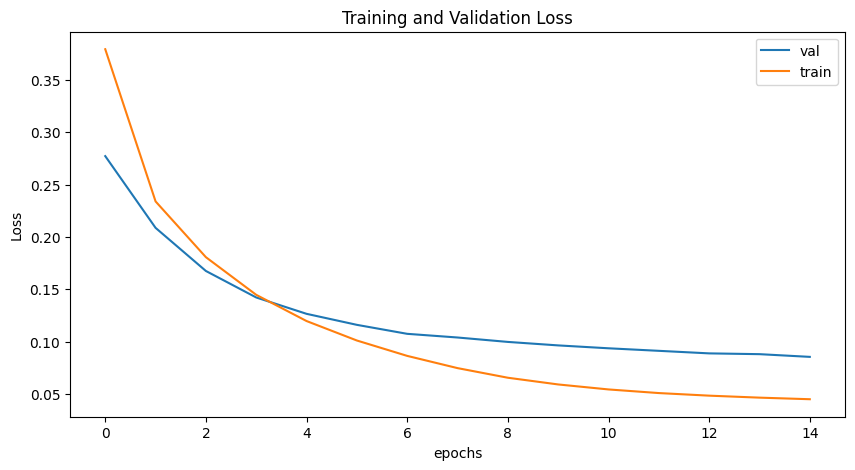

In [22]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
# from torch.utils.tensorboard import SummaryWriter

# logdir = "./runs/"
# writer = SummaryWriter(logdir)


In [24]:
# !tensorboard --logdir=./runs

In [25]:
# writer.close()

# Test

## BLEU on train set

In [ ]:
score = bleu(train_loader, model, dm, device)
print(f"Bleu score {score*100:.2f}")

In [36]:
score = bleu(val_loader, model, dm, device)
print(f"Bleu score {score*100:.2f}")

Bleu score 53.37


## BLEU on test set

In [37]:
score = bleu(test_loader, model, dm, device)
print(f"Bleu score {score*100:.2f}")

Bleu score 52.17


## loading checkpoint

In [ ]:
# model = Transformer(
#     src_vocab_size, trg_vocab_size, 
#     src_pad_idx, src_pad_idx, 
#     device=device
# ).to(device)

# optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.CrossEntropyLoss(ignore_index=src_pad_idx)

# load_checkpoint("/kaggle/working/my_checkpoint.pth.tar", model, optimizer, device)

In [ ]:
# score = bleu(test_loader, model, dm, device)
# print(f"Bleu score {score*100:.2f}")

## Inference on a new sentence

In [30]:
import math
import seaborn as sns

In [31]:
def inference_sentecnce(raw_sentence):
    global cross_attention
    input_tokens = dm.tokenizer_fr.encode(raw_sentence) 
    input_tensor = torch.LongTensor(input_tokens)
    
    translated_sentence = decoding(
        model, input_tensor, dm, device
    )
    
    print(f"Translated example sentence: \n {' '.join(translated_sentence)}")
    
    src_tokens = [dm.tokenizer_fr.bos_token]
    for token in raw_sentence.split():
        res_token = dm.tokenizer_fr.encode(token)
        src_tokens.extend(len(res_token[1:-1])*[token])
    src_tokens.append(dm.tokenizer_fr.eos_token)
    tgt_tokens = translated_sentence

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    for i in range(4):
        axes[i//2][i%2].set_title(f"Frame {i+1}")

        plt.xlabel("Source (Key)")
        plt.ylabel("Target (Query)")
        plt.title("Cross-Attention")
        sns.heatmap(
            # cross_attention.reshape(-1, cross_attention.shape[2], cross_attention.shape[3])[i].numpy(), 
            cross_attention.reshape(-1, cross_attention.shape[2], cross_attention.shape[3])[i].detach().cpu().numpy(), 
            xticklabels=src_tokens, 
            yticklabels=tgt_tokens, 
            cmap='viridis',
            annot=False,
            ax=axes[i//2][i%2]
        )
    
    plt.show()

Translated example sentence: 
 ▁i ▁am ud ▁duty ▁that ▁with ▁you ▁. </s>


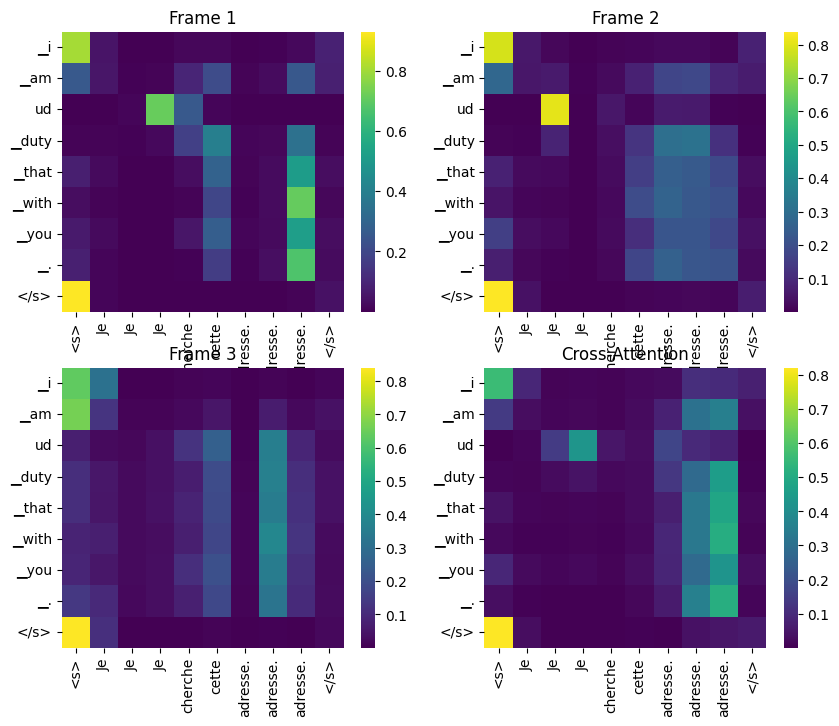

In [32]:
raw_sentence = "Je cherche cette adresse." # I am looking for this address.
inference_sentecnce(raw_sentence)

Translated example sentence: 
 ▁i ▁m ▁thank ▁tired ▁of ▁the ▁sens ▁. </s>


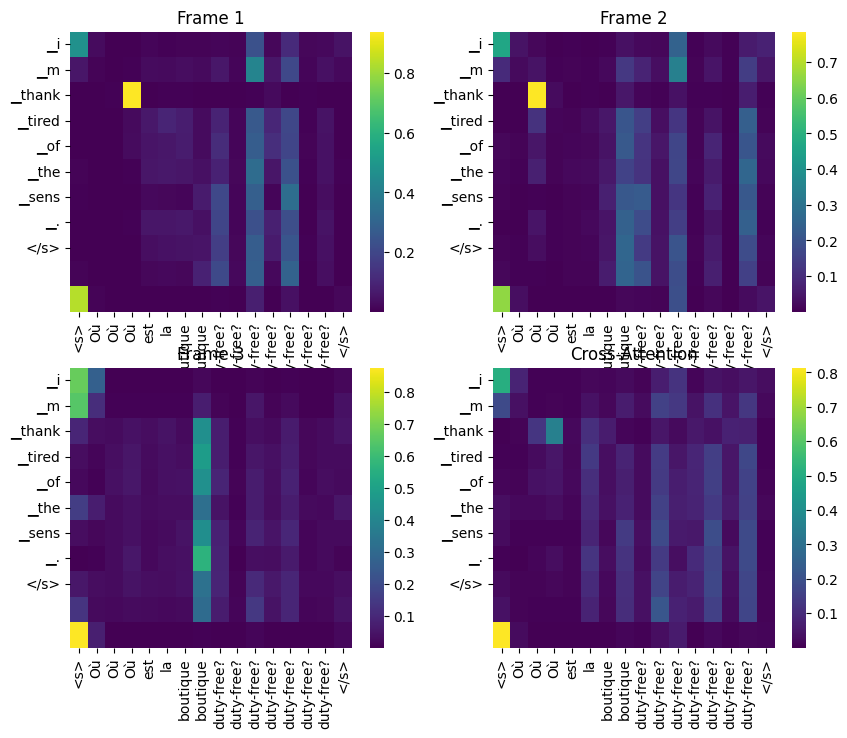

In [33]:
raw_sentence = "Où est la boutique duty-free?" # Where are the duty-free shop?
inference_sentecnce(raw_sentence)

Translated example sentence: 
 ▁i ▁m ▁grow ▁bench ▁bench ▁for ▁you ▁. </s>


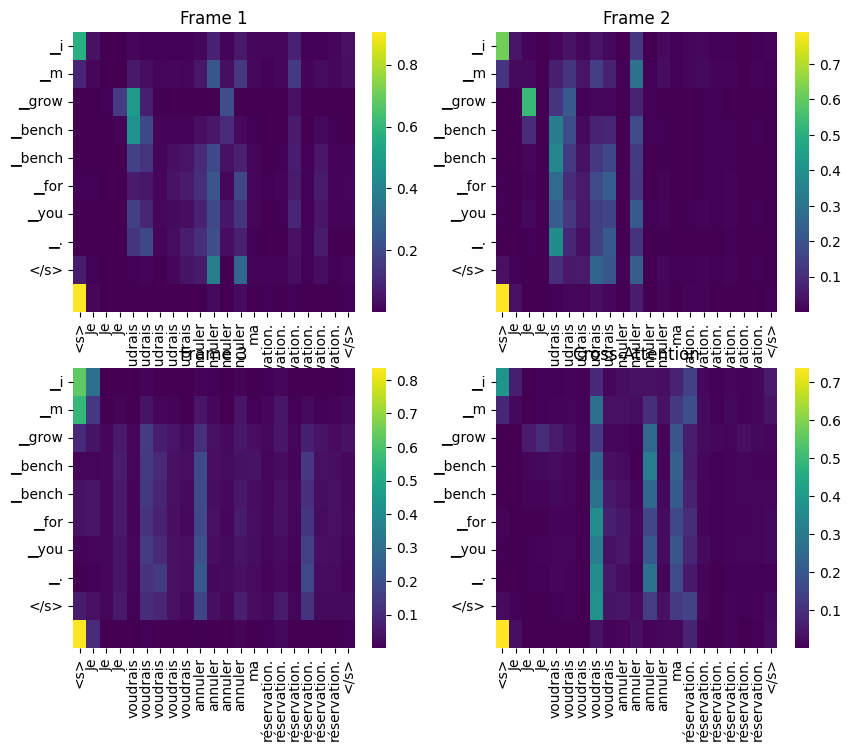

In [34]:
raw_sentence = "Je voudrais annuler ma réservation." # I would like to cancel my reservation.
inference_sentecnce(raw_sentence)

Translated example sentence: 
 ▁i ▁m ▁at ▁the work ▁of ▁my id s ▁. </s>


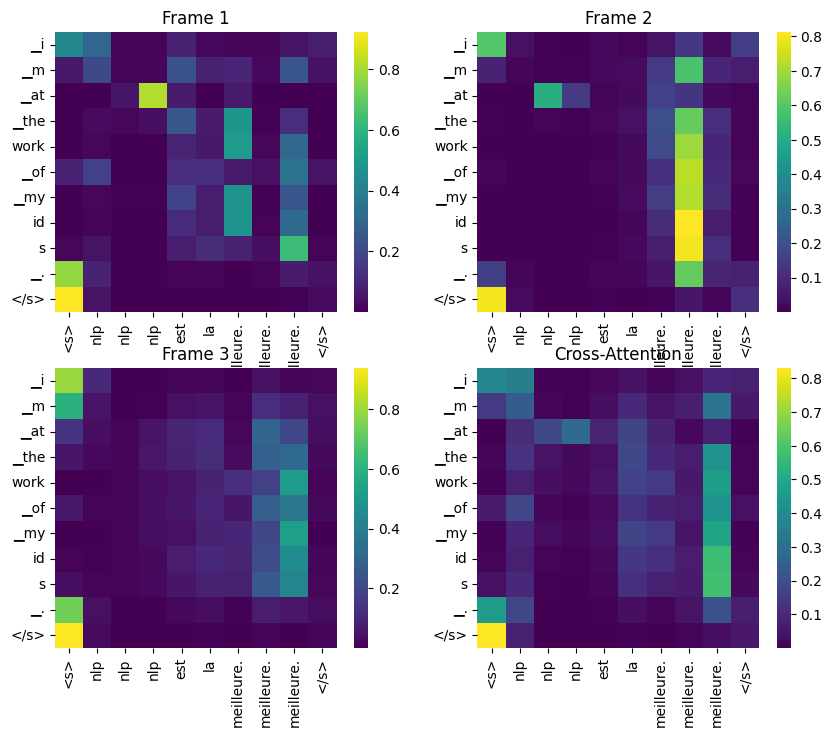

In [35]:
raw_sentence = "nlp est la meilleure." # nlp is the best.
inference_sentecnce(raw_sentence)

# Hyperparameter Tuning

In [ ]:
# !pip install optuna

In [ ]:
# import optuna
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.cuda.amp import GradScaler, autocast # Mixed Precision
# from tqdm import tqdm

# # --- 1. OPTIMIZED TRAINING FUNCTION ---
# def train_epoch(model, loader, optimizer, criterion, scaler, device, max_grad_norm):
#     model.train()
#     running_loss = 0.0
    
#     # Iterate through data
#     for source, target in loader:
#         source = source.to(device)
#         target = target.to(device)

#         # Forward pass with Mixed Precision
#         with autocast():
#             output = model(source, target[:-1]) # Drop last token for input
            
#             output = output.reshape(-1, output.shape[2]) # Flatten
#             target = target[1:].reshape(-1) # Drop start token for target
            
#             loss = criterion(output, target)

#         # Backward pass
#         optimizer.zero_grad()
#         scaler.scale(loss).backward()
        
#         # Unscale and Clip Gradients
#         scaler.unscale_(optimizer)
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item()

#     return running_loss / len(loader)

# # --- 2. OPTIMIZED VALIDATION FUNCTION ---
# def val_epoch(model, loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
    
#     with torch.no_grad():
#         for source, target in loader:
#             source = source.to(device)
#             target = target.to(device)

#             with autocast():
#                 output = model(source, target[:-1])
#                 output = output.reshape(-1, output.shape[2])
#                 target = target[1:].reshape(-1)
#                 loss = criterion(output, target)
                
#             running_loss += loss.item()
            
#     return running_loss / len(loader)

# # --- 3. OPTUNA OBJECTIVE FUNCTION ---
# def objective(trial):
#     # A. Suggest Hyperparameters
#     # ----------------------------------------
#     learning_rate = trial.suggest_float("lr", 1e-5, 5e-4, log=True)
#     batch_size = trial.suggest_categorical("batch_size", [32, 64])
#     embed_size = trial.suggest_categorical("embed_size", [256, 512])
#     num_heads = trial.suggest_categorical("num_heads", [4, 8])
#     num_layers = trial.suggest_int("num_layers", 2, 6) # Layers for both encoder/decoder
#     dropout = trial.suggest_float("dropout", 0.1, 0.3)
    
#     # Ensure embed_size is divisible by num_heads
#     if embed_size % num_heads != 0:
#         raise optuna.TrialPruned()

#     # B. Setup Data & Model
#     # ----------------------------------------
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     # Re-initialize loaders with the new batch_size
#     # Note: Replace 'get_loaders' with your actual data loading function
#     train_loader, val_loader = get_loaders(batch_size=batch_size) 

#     model = Transformer(
#         src_vocab_size=dm.tokenizer_fr.vocab_size,
#         trg_vocab_size=dm.tokenizer_en.vocab_size,
#         src_pad_idx=dm.tokenizer_en.pad_token_id,
#         trg_pad_idx=dm.tokenizer_en.pad_token_id,
#         embed_size=embed_size,
#         num_heads=num_heads,
#         num_encoder_layers=num_layers,
#         num_decoder_layers=num_layers,
#         dropout=dropout,
#         device=device
#     ).to(device)

#     # Use AdamW (better for Transformers than SGD)
#     optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
#     criterion = nn.CrossEntropyLoss(
#         ignore_index=dm.tokenizer_en.pad_token_id, 
#         label_smoothing=0.1
#     )
    
#     scaler = GradScaler() # For Mixed Precision
    
#     # C. Training Loop (Shortened for Tuning)
#     # ----------------------------------------
#     # We only train for a few epochs per trial to save time
#     tune_epochs = 5 
    
#     for epoch in range(tune_epochs):
#         train_loss = train_epoch(model, train_loader, optimizer, criterion, scaler, device, max_grad_norm=1.0)
#         val_loss = val_epoch(model, val_loader, criterion, device)
        
#         # Report intermediate result to Optuna
#         trial.report(val_loss, epoch)

#         # Handle Pruning (Stop bad trials early)
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     return val_loss

# # --- 4. RUN THE STUDY ---
# if __name__ == "__main__":
#     print("Starting Hyperparameter Tuning...")
    
#     study = optuna.create_study(direction="minimize") # Minimize Validation Loss
    
#     # Run 20 trials (experiments)
#     study.optimize(objective, n_trials=20) 

#     print("\n------------------------------------------------")
#     print("Tuning Complete!")
#     print("Best Trial:")
#     trial = study.best_trial
#     print(f"  Value (Val Loss): {trial.value}")
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print(f"    {key}: {value}")